# PURLs

The Internet Archive [took over the maintenance](https://blog.archive.org/2016/09/27/persistent-url-service-purl-org-now-run-by-the-internet-archive/) of the purl.org service from OCLC 5 years ago. I recently learned that the purl.org service is some caching + a Python program that fetches data store in the Internet Archive's storage. It turns out each purl.org namespace like *https://purl.org/dc/* is an item in the [purl_collection](https://archive.org/details/purl_collection). Each item has a JSON document that containins the URL patterns used by the namespace.

For example here's the one for DublinCore:



In [3]:
import json
import requests

dc = requests.get('https://archive.org/download/purl_dc/purl_dc_purl.json').json()
print(json.dumps(dc, indent=2))

{
  "name": "/dc",
  "created": "2009-07-22 17:44:37",
  "maintainer": {
    "fullname": "Dublin Core Metadata Initiative",
    "userid": "purl@dublincore.net",
    "email": "purl@dublincore.net",
    "affiliation": "DCMI"
  },
  "purls": [
    {
      "type": "302",
      "target": "http://purl.org/DC/",
      "name": "/DC",
      "created": "2009-07-22 19:36:26",
      "modified": "2012-11-16 14:25:18"
    },
    {
      "type": "partial",
      "target": "http://dublincore.org/",
      "name": "/DC/",
      "created": "2009-07-23 01:48:18",
      "modified": "2012-11-16 14:25:37"
    },
    {
      "type": "302",
      "target": "http://dublincore.org/DCMI.rdf",
      "name": "/dc/aboutdcmi",
      "created": "2010-02-28 08:51:06",
      "modified": "2010-02-28 08:51:06"
    },
    {
      "type": "partial",
      "target": "/dc/test/terms/",
      "name": "/dc/test/terms",
      "created": "2012-05-28 16:59:52",
      "modified": "2012-06-09 12:26:35"
    },
    {
      "type": "pa

There is also a history of the previous versions:

In [19]:
hist = requests.get('https://archive.org/download/purl_dc/purl_dc_purl_history.json').json()
print(json.dumps(hist, indent=2))

{
  "history": [
    {
      "name": "/dc/topicmap",
      "type": "302",
      "target": "http://orc.dev.oclc.org:9016/iiop/TopicMap?browse=dublin_core",
      "status": 0,
      "modtime": "2009-07-22 19:11:39",
      "user": "admin"
    },
    {
      "name": "/DC",
      "type": "302",
      "target": "http://purl.org/DC/",
      "status": 0,
      "modtime": "2009-07-22 19:36:26",
      "user": "admin"
    },
    {
      "name": "/DC",
      "type": "302",
      "target": "http://purl.org/DC/",
      "status": 1,
      "modtime": "2012-11-16 14:25:18",
      "user": "admin"
    },
    {
      "name": "/DC/",
      "type": "partial",
      "target": "http://dublincore.org/",
      "status": 0,
      "modtime": "2009-07-23 01:48:18",
      "user": "admin"
    },
    {
      "name": "/DC/",
      "type": "partial",
      "target": "http://dublincore.org/",
      "status": 1,
      "modtime": "2012-11-16 14:25:37",
      "user": "admin"
    },
    {
      "name": "/dc/science",
      

## Download PURL

So we can search for all of the namespaces and download their JSON namespace data using the [internetarchive](https://pypi.org/project/internetarchive/) Python library for interacting with the Internet Archive storage API.

In [ ]:
import time
import pathlib

from internetarchive import search_items, download

data_dir = pathlib.Path('data/purl')

for match in search_items('collection:purl_collection'):
    item_id = match['identifier']
    
    # if it hasn't been downloaded yet
    if not (data_dir / item_id).is_dir():
        download(item_id, destdir=data_dir, glob_pattern='*.json')
        time.sleep(.5)
    else:
        print(f'already downloaded {item_id}')

Running this *for a few days* resulted in 21,680 namespace items being downloaded. 26 IA items were not downloaded because they lacked the JSON files needed to understand them as PURL namespaces. Here is a list of those in case you are interested:

* purl_NetLink
* purl_RadioNegashi.net
* purl_SeanPetiya
* purl_TechOpsTraining
* purl_candycesessayprompt
* purl_cyber_cbo
* purl_gramaticie
* purl_gzirtadiss
* purl_iip-srm.owl
* purl_iot_vocab_m3
* purl_ist_interoperability-key-point
* purl_ist_interoperable-quality-metric
* purl_jorge_gramie
* purl_jrgjuanf_gramie
* purl_linkeddatatest
* purl_map4scrutiny_core
* purl_net_NetLink
* purl_net_overload
* purl_oblp
* purl_pradeo_cbo
* purl_schema_cocoon
* purl_swarms
* purl_unibomp_schema
* purl_xapi_ontology_
* purl_xinli
* purl_yoolib
 

## Namespace Creation

Given that the JSON object for each namespace we can look to see when they were created. First lets create a generator function that returns metadata for each PURL namespace, and test it out.

In [4]:
def purls_metadata():
    data = pathlib.Path('data/purl')
    for ns_dir in data.iterdir():
        ns = ns_dir.name
        json_file = ns_dir / f"{ns}_purl.json"
        if json_file.is_file():
            yield json.load(json_file.open())
        
next(purls_metadata())

{'name': '/umarchives/mum00516',
 'created': '2009-07-22 15:56:29',
 'maintainer': {'fullname': 'University Special Collections and Archives',
  'email': 'archive@olemiss.edu',
  'affiliation': 'University of Mississippi',
  'userid': 'OLEMISSARCHIVES'},
 'purls': [{'target': 'http://www.olemiss.edu/depts/general_library/archives/finding_aids/MUM00516.html',
   'name': '/umarchives/MUM00516/',
   'created': '2009-07-23 00:10:01',
   'modified': '2009-11-04 10:08:07',
   'type': '301'}]}

Looks good so now we can make a DataFrame for the metadata.

In [5]:
import pandas

df = pandas.json_normalize(purls_metadata())
df['created'] = pandas.to_datetime(df['created'])

Now we can group by month 

In [6]:
counts = df.created.groupby(by=[df.created.dt.year]).count()
counts

created
2009    15921
2010      271
2011      267
2012      197
2013      220
2014      135
2015        9
2016      380
2017      983
2018      852
2019      641
2020      981
2021     1037
Name: created, dtype: int64

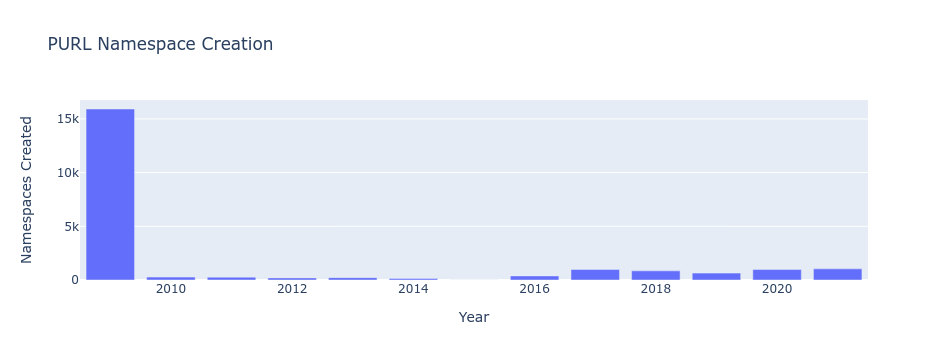

In [75]:
from plotly import express as xp

fig = xp.bar(counts, labels={'value': 'Namespaces Created', 'index': 'Year'}, title='PURL Namespace Creation')
fig.layout.update(showlegend=False)
fig

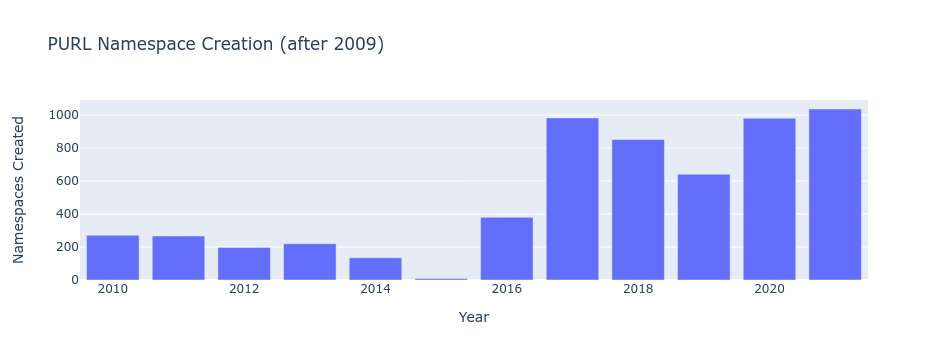

In [76]:
fig = xp.bar(counts[counts.index > 2009], labels={'value': 'Namespaces Created', 'index': 'Year'}, title='PURL Namespace Creation (after 2009)')
fig.layout.update(showlegend=False)
fig

What were some of the namespaces that were created this year?

In [9]:
purl2021 = df[df['created'].dt.year == 2021]
purl2021.to_csv('data/purls2021.csv', index=False)
purl2021

,name,created,purls,maintainer.fullname,maintainer.email,maintainer.affiliation,maintainer.userid,maintainer
6,/cube,2021-11-10 19:59:43,NaN,NaN,NaN,NaN,NaN,NaN
13,/mhk,2021-04-20 11:44:26,"[{'type': '302', 'name': '/mhk/1', 'modified':...",NaN,NaN,NaN,NaN,NaN
42,/spc93/test1,2021-04-29 09:33:46,"[{'created': '2021-04-29 09:55:40', 'target': ...",NaN,NaN,NaN,NaN,NaN
72,/orphanetws/mapping/from/orphanet,2021-04-28 14:24:10,[{'target': 'http://155.133.131.171:8080/Mappi...,NaN,NaN,NaN,NaN,NaN
78,/sampling_ontology,2021-12-02 16:37:18,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
21814,/schwigri/2019/tokyo-tech/report/en,2021-11-05 00:37:02,[{'name': '/schwigri/2019/tokyo-tech/report/en...,NaN,NaN,NaN,NaN,NaN
21823,/m4m,2021-08-23 13:01:16,"[{'name': '/m4m', 'type': '302', 'target': 'ht...",NaN,NaN,NaN,NaN,NaN
21854,/lmjxt,2021-03-27 12:06:36,"[{'domain': '/lmjxt', 'type': '302', 'name': '...",NaN,NaN,NaN,NaN,NaN
21872,/waerwadcz,2021-11-17 18:28:28,NaN,NaN,NaN,NaN,NaN,NaN


## Namespace Updates

Similarly it's possible to use the history file (if it's present) to see how much namespaces are being updated. Note I ran across a few examples of invalid JSON so it's important to guard against those, for example:

https://ia801206.us.archive.org/20/items/purl_.fp/purl_.fp_purl_history.json

This generator will return a simpler dictionary of names and edit datetime.


In [85]:
def purls_updates():
    data = pathlib.Path('data/purl')
    for ns_dir in data.iterdir():
        ns = ns_dir.name
        metadata_file = ns_dir / f"{ns}_purl.json"
        history_file = ns_dir / f"{ns}_purl_history.json"
        if metadata_file.is_file() and history_file.is_file():
            try:
                meta = json.load(metadata_file.open())
                maintainer = meta['maintainer']['affiliation'] if 'maintainer' in meta else '???' 
                history = json.load(history_file.open())
                for edit in history['history']:
                    yield {'ns': meta['name'], 'name': maintainer, 'update': edit['modtime']}
            except Exception as e:
                print(f'Error when processing {ns}: {e}')
                break
        
next(purls_updates())

{'ns': '/umarchives/mum00516',
 'name': 'University of Mississippi',
 'update': '2009-07-23 00:10:01'}

And we can recreate our DataFrame with the new `last_update` column.

In [86]:
df2 = pandas.json_normalize(purls_updates())
df2['update'] = pandas.to_datetime(df2['update'])
df2

Error when processing purl_tod_test: 'NoneType' object is not subscriptable


,ns,name,update
0,/umarchives/mum00516,University of Mississippi,2009-07-23 00:10:01
1,/umarchives/mum00516,University of Mississippi,2009-11-04 10:08:07
2,/oclc/rspd,"OCLC, Office of Research",2009-07-22 23:10:49
3,/net/gandalf,,2009-07-22 22:55:06
4,/net/macquigg,,2009-07-23 01:28:25
...,...,...,...
395609,/tuisp/online,,2009-07-22 22:34:18
395610,/net/apas,Erisian Coop,2009-07-22 18:40:02
395611,/oclc/oluc/42917920,PURL Server,2009-07-23 03:09:25
395612,/oclc/oluc/43189125,PURL Server,2009-07-22 21:38:21


In [88]:
updates = df2['update'].groupby(by=[df2['update'].dt.year]).count()
updates

update
2009    182174
2010      4032
2011     63736
2012     49756
2013     29650
2014     26950
2015     26503
2016      5334
2017      2328
2018      1390
2019      1171
2020      1230
2021      1360
Name: update, dtype: int64

Again it looks like there were a bunch of updates given a date at the start of some kind of migration. So lets ignore those:

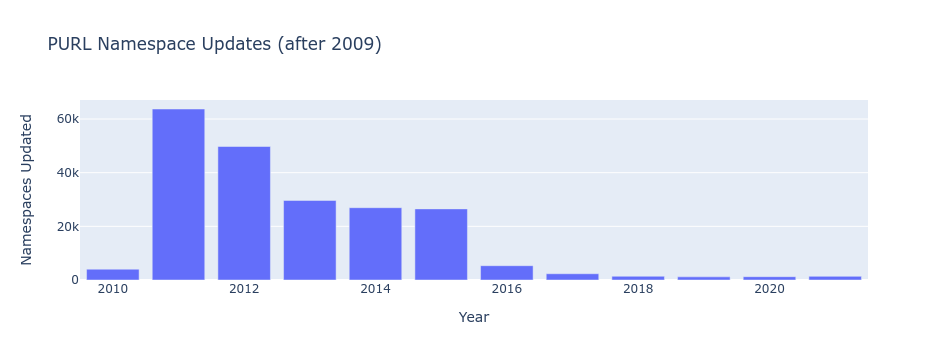

In [84]:
fig = xp.bar(updates[counts.index > 2009], labels={'value': 'Namespaces Updated', 'index': 'Year'}, title='PURL Namespace Updates (after 2009)')
fig.layout.update(showlegend=False)
fig

So there has been a drastic fall in how often the namespaces are updated once it moved to the Internet Archive?

## Most Updated

What namespaces are updated the most?


In [95]:
ns_counts = df2.groupby(by=df2['ns']).count()
ns_counts = ns_counts.sort_values('update', ascending=False)
ns_counts.head(50)

,name,update
ns,,
/oclc/oluc,140539,140539
/opendata-cz,28393,28393
/procurement,20760,20760
/yoolib/inha,19057,19057
/yoolib/bmsaintomer,18480,18480
/net,18415,18415
/yoolib/bmaixenprovence,14931,14931
/yoolib/bmdieppe,14532,14532
/5060d4,13461,13461


How about if we look by affiliate name?

In [96]:
name_counts = df2.groupby(by=df2['ns']).count()
name_counts = ns_counts.sort_values('update', ascending=False)
name_counts.head(50)

,name,update
ns,,
/oclc/oluc,140539,140539
/opendata-cz,28393,28393
/procurement,20760,20760
/yoolib/inha,19057,19057
/yoolib/bmsaintomer,18480,18480
/net,18415,18415
/yoolib/bmaixenprovence,14931,14931
/yoolib/bmdieppe,14532,14532
/5060d4,13461,13461


In [98]:
oluc = df2[df2['ns'] == '/oclc/oluc']
oluc_counts = oluc.groupby(by=oluc['update'].dt.year).count()
oluc_counts

,ns,name,update
update,,,
2009,140539,140539,140539


Oh so these account for the big ingest in 2009!? How about `opendata-cz`?

In [101]:
cz = df2[df2['ns'] == '/opendata-cz']
cz = cz.groupby(by=cz['update'].dt.year).count()
cz

,ns,name,update
update,,,
2011,28393,28393,28393


It looks like this also was a big ingest at a point in time? Moving down the list a bit how about `/net`?

In [102]:
net = df2[df2['ns'] == '/net']
net = net.groupby(by=net['update'].dt.year).count()
net

,ns,name,update
update,,,
2009,15112,15112,15112
2010,598,598,598
2011,371,371,371
2012,381,381,381
2013,341,341,341
2014,740,740,740
2015,864,864,864
2020,8,8,8


## Does it Work?

How many of the PURLs still work? First we need to get a list of the current URLs from the metadata.

In [27]:
def purl_targets():
    data = pathlib.Path('data/purl')
    for ns_dir in data.iterdir():
        ns = ns_dir.name
        metadata_file = ns_dir / f"{ns}_purl.json"
        if metadata_file.is_file():
            meta = json.load(metadata_file.open())
            if meta.get('purls') is None: continue
            if meta.get('maintainer') is not None and meta['maintainer'].get('affiliation') is not None:
                maintainer = meta['maintainer']['affiliation']
            else:
                maintainer = '???'
            for purl in meta['purls']:
                yield {
                    'maintainer': maintainer,
                    'target': purl['target'],
                    'created': purl['created'],
                    'modified': purl.get('modified')
                }
        
next(purl_targets())

{'maintainer': 'University of Mississippi',
 'target': 'http://www.olemiss.edu/depts/general_library/archives/finding_aids/MUM00516.html',
 'created': '2009-07-23 00:10:01',
 'modified': '2009-11-04 10:08:07'}

In [29]:
urls = pandas.json_normalize(purl_targets()).sort_values('modified', ascending=False)
urls

,maintainer,target,created,modified
69443,???,http://scientiageneralis.com.br/index.php/SG/a...,2021-12-15 13:51:09,2021-12-15 13:51:09
482588,???,https://www.vocoreg.org/home/CALLISTO/master,2021-12-15 09:04:48,2021-12-15 09:04:48
39157,???,http://www.iseor-formations.com/pdf/ACTESCOLOD...,2021-12-12 15:14:44,2021-12-12 15:14:44
467630,???,https://pubs.opengroup.org/architecture/archim...,2021-12-11 08:35:28,2021-12-11 08:35:28
467629,???,https:https://pubs.opengroup.org/architecture/...,2021-12-11 08:34:21,2021-12-11 08:34:21
...,...,...,...,...
405632,PURL Server,http://saifmohammad.com/WebPages/lexicons.html...,2015-10-16 14:09:08,None
405633,PURL Server,http://comodi.sems.uni-rostock.de/2015-10-09,2015-10-21 08:17:26,None
405634,PURL Server,http://comodi.sems.uni-rostock.de/2015-10-20,2015-10-21 08:17:39,None
405636,PURL Server,http://semantic.cs.put.poznan.pl/dmo/DMOP/DMOP...,2015-10-23 05:35:27,None


So we've got 405,637 URLs. That would take a while to check all of them. How about we sample them? This [calculator](https://www.qualtrics.com/blog/calculating-sample-size/) says if we want a 99% confidence level and a 5% margin of error we can go with a sample size of 662.

In [30]:
url_sample = urls.sample(662)
url_sample

,maintainer,target,created,modified
330279,PURL Server,http://www.terafsada.com/adtrackz/go.php?c=cgj...,2009-07-22 22:00:57,2009-07-22 22:00:57
31053,Newcastle University,http://greycite.knowledgeblog.org/?uid=15961,2014-08-18 00:28:39,2014-08-18 00:28:39
232876,"OCLC, Office of Research",http://dos10.nysed.gov/cgi-bin/nysedoc?index1=...,2009-07-22 23:29:15,2009-07-22 23:29:15
55170,PURL Server,http://my.yoolib.com/ad65/?p=7357,2013-06-11 06:11:14,2013-06-11 06:11:14
143939,"OCLC, Office of Research",http://www.gorr.state.ny.us/gorr/zoning.html,2009-07-22 17:52:09,2009-07-22 17:52:09
...,...,...,...,...
239002,"OCLC, Office of Research",http://gowest.coalliance.org/cgi-bin/imager?20...,2009-07-22 23:56:24,2009-07-22 23:56:24
326140,PURL Server,http://maps.yahoo.com/py/ddResults.py?Pyt=Tmap...,2009-07-22 19:34:54,2009-07-22 19:34:54
400829,PURL Server,http://www.library.nd.edu/ddw/public/resource_...,2009-07-23 01:27:09,None
119930,PURL Server,http://my.yoolib.net/bmsaintomer/?p=8679,2012-04-27 11:15:25,2012-04-27 11:15:25


Knowing whether a URL is working or not is actually a really tricky thing. A URL could appear to work but point at something completely different than what was intended. A URL could return 200 OK but the page could read that the resource is gone. It's very tricky. But lets just take a simplistic look at the status code from the response. Even then we need to be carefult to guard against errors where the host name no longer exists, and where the connection timeouts when the webserver doesn't respond in a timely manner. Since this can take a while its' useful to print out what's happening as it is going.

In [ ]:
def status_code(url):
    try:
        resp = requests.get(url, timeout=10)
        print(f'{resp.status_code} {url}')
        return str(resp.status_code)
    except Exception as e:
        print(f'{e} {url}')
        return 'other'

In [78]:
status_code('http://my.yoolib.net/bmsaintomer/?p=8679')

404 http://my.yoolib.net/bmsaintomer/?p=8679


'404'

This does not bode well, but lets run this for our sample.

In [82]:
url_sample['status_code'] = url_sample['target'].apply(status_code)

HTTPConnectionPool(host='www.terafsada.com', port=80): Max retries exceeded with url: /adtrackz/go.php?c=cgjobssales (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc5f5d62be0>: Failed to establish a new connection: [Errno -2] Name or service not known')) http://www.terafsada.com/adtrackz/go.php?c=cgjobssales
HTTPConnectionPool(host='greycite.knowledgeblog.org', port=80): Max retries exceeded with url: /?uid=15961 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x7fc5f5d62f40>, 'Connection to greycite.knowledgeblog.org timed out. (connect timeout=10)')) http://greycite.knowledgeblog.org/?uid=15961
HTTPConnectionPool(host='dos10.nysed.gov', port=80): Max retries exceeded with url: /cgi-bin/nysedoc?index1=39286861 (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc5f5d62fa0>: Failed to establish a new connection: [Errno -2] Name or service not known')) http://dos10.nysed.gov/cgi-bin/nysedoc?index1=3

Just eyeballing these results its clear that there are some large pockets of URLs at some hosts like `my.yoolib.com` so in order to make claims about maintainers in general we would want to have a smarter sampling method that doesn't over sample particular maintainers. But lets just take a look at these URLs.

In [49]:
url_sample['status_code'].value_counts()

404.0    259
200.0    213
403.0      6
406.0      2
500.0      2
400.0      2
503.0      2
420.0      1
Name: status_code, dtype: int64

But lets try again but this time sample based on the namespace.

In [50]:
len(df)

21894

The calculator says for 99% confidence and 5% margin of error we should use 644.

In [72]:
ns_sample = df[df['purls'].notna()].sample(644)
ns_sample

,name,created,purls,maintainer.fullname,maintainer.email,maintainer.affiliation,maintainer.userid,maintainer
12753,/oclc/oluc/43080762,2009-07-22 16:28:35,[{'target': 'http://webdoc.lhl.mo.us/aiche99/9...,User of Steel,null,PURL Server,admin,NaN
17477,/net/2995,2009-07-22 17:37:29,"[{'target': 'http://topsiteforyou.com/form', '...",Kevin McCarry,woben2@gmail.com,,ELEMENT,NaN
9135,/umarchives/mum00592,2009-07-22 15:55:58,[{'target': 'http://www.olemiss.edu/depts/gene...,University Special Collections and Archives,archive@olemiss.edu,University of Mississippi,OLEMISSARCHIVES,NaN
16381,/uporto/id,2013-05-13 06:49:51,[{'target': 'https://inqueritos.up.pt/limesurv...,U.PORTO-REIT:DUD-SERU,helpdesk@reit.up.pt,uporto,uporto1reit2dud3seru,NaN
21797,/oclc/oluc/43272755,2009-07-22 16:15:11,[{'target': 'http://libwww.syr.edu/information...,User of Steel,null,PURL Server,admin,NaN
...,...,...,...,...,...,...,...,...
13757,/obo/obi/wiki,2009-07-22 16:53:26,"[{'target': 'http://obi-ontology.org/page/', '...",Alan Ruttenberg,alanruttenberg@gmail.com,Science Commons,ALANRUTTENBERG,NaN
5662,/sh,2017-11-16 04:50:56,"[{'name': '/sh', 'type': 'partial', 'created':...",NaN,NaN,NaN,NaN,NaN
18659,/net/netrier,2009-07-22 17:11:30,[{'target': 'http://www.mediasanto.com/cboxser...,sco,contact@mediasanto.com,mediasanto,MEDIASANTO,NaN
8072,/yoolib/ad24,2011-09-16 04:53:45,[{'target': 'http://my.yoolib.net/ad24/?p=832'...,User of Steel,null,PURL Server,admin,NaN


Now we need a function that will get a URL for one of these namespaces. It's actually embedded in the `purls` series. This function can randomly pick one of the URLs in the namespace or simply return it if there's only one.

In [75]:
import random

def ns_url(purls):
    if not purls:
        return None
    targets = [p['target'] for p in purls]
    if len(targets) == 1:
        return targets[0]
    elif len(targets) == 0:
        return None
    else:
        return random.choice(targets)                              

In [76]:
ns_sample['sample_url'] = ns_sample['purls'].apply(ns_url)
ns_sample

,name,created,purls,maintainer.fullname,maintainer.email,maintainer.affiliation,maintainer.userid,maintainer,sample_url
12753,/oclc/oluc/43080762,2009-07-22 16:28:35,[{'target': 'http://webdoc.lhl.mo.us/aiche99/9...,User of Steel,null,PURL Server,admin,NaN,http://webdoc.lhl.mo.us/aiche99/99an22a.pdf
17477,/net/2995,2009-07-22 17:37:29,"[{'target': 'http://topsiteforyou.com/form', '...",Kevin McCarry,woben2@gmail.com,,ELEMENT,NaN,http://topsiteforyou.com/form
9135,/umarchives/mum00592,2009-07-22 15:55:58,[{'target': 'http://www.olemiss.edu/depts/gene...,University Special Collections and Archives,archive@olemiss.edu,University of Mississippi,OLEMISSARCHIVES,NaN,http://www.olemiss.edu/depts/general_library/a...
16381,/uporto/id,2013-05-13 06:49:51,[{'target': 'https://inqueritos.up.pt/limesurv...,U.PORTO-REIT:DUD-SERU,helpdesk@reit.up.pt,uporto,uporto1reit2dud3seru,NaN,https://inqueritos.up.pt/limesurvey/557995
21797,/oclc/oluc/43272755,2009-07-22 16:15:11,[{'target': 'http://libwww.syr.edu/information...,User of Steel,null,PURL Server,admin,NaN,http://libwww.syr.edu/information/media/archiv...
...,...,...,...,...,...,...,...,...,...
13757,/obo/obi/wiki,2009-07-22 16:53:26,"[{'target': 'http://obi-ontology.org/page/', '...",Alan Ruttenberg,alanruttenberg@gmail.com,Science Commons,ALANRUTTENBERG,NaN,http://obi-ontology.org
5662,/sh,2017-11-16 04:50:56,"[{'name': '/sh', 'type': 'partial', 'created':...",NaN,NaN,NaN,NaN,NaN,https://sci.pe
18659,/net/netrier,2009-07-22 17:11:30,[{'target': 'http://www.mediasanto.com/cboxser...,sco,contact@mediasanto.com,mediasanto,MEDIASANTO,NaN,http://www.mediasanto.com/cboxserver/cbs?isan=...
8072,/yoolib/ad24,2011-09-16 04:53:45,[{'target': 'http://my.yoolib.net/ad24/?p=832'...,User of Steel,null,PURL Server,admin,NaN,http://my.yoolib.com/ad24/?p=4338


Now lets check these.

In [81]:
ns_sample['status_code'] = ns_sample['sample_url'].apply(status_code)

HTTPConnectionPool(host='webdoc.lhl.mo.us', port=80): Max retries exceeded with url: /aiche99/99an22a.pdf (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc5fb2c5c10>: Failed to establish a new connection: [Errno -2] Name or service not known')) http://webdoc.lhl.mo.us/aiche99/99an22a.pdf
HTTPConnectionPool(host='topsiteforyou.com', port=80): Max retries exceeded with url: /form (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc5fb2c5640>: Failed to establish a new connection: [Errno -2] Name or service not known')) http://topsiteforyou.com/form
200 http://www.olemiss.edu/depts/general_library/archives/finding_aids/MUM00592.html
404 https://inqueritos.up.pt/limesurvey/557995
HTTPConnectionPool(host='libwww.syr.edu', port=80): Max retries exceeded with url: /information/media/archive/main.htm (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc5fb2c5490>: Failed to establish a new connection: [Err

Even here we can see oversampling of some domains like  `www.olemiss.edu`. I guess they are creating multiple PURL namespaces for things?

In [127]:
s = ns_sample.value_counts('status_code', dropna=False)
s

status_code
NaN    262
200    236
404    123
403     11
503      4
406      3
400      2
999      2
401      1
???      1
dtype: int64

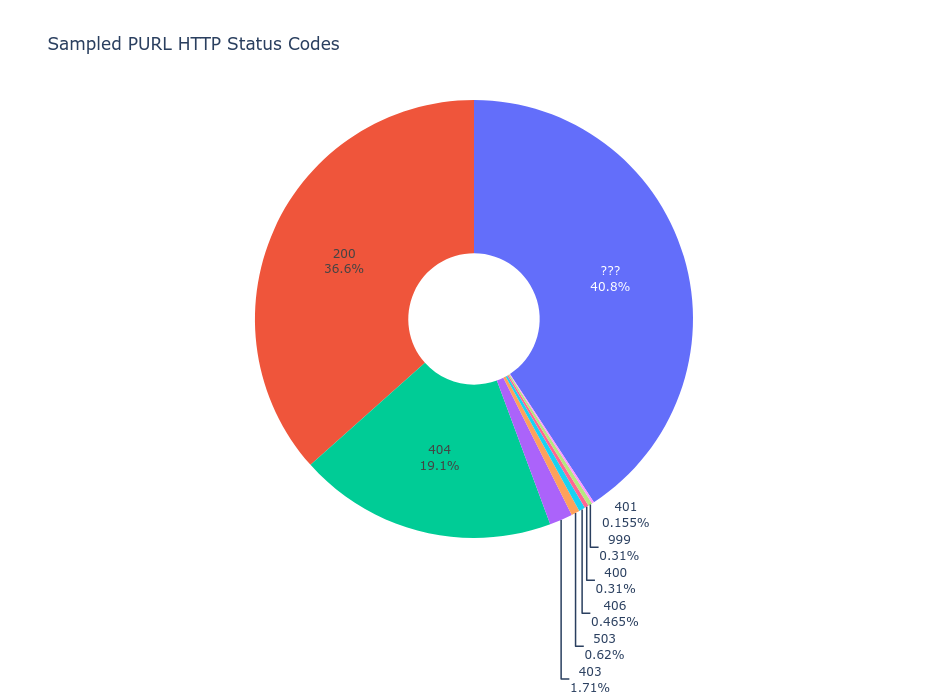

In [133]:
import plotly.graph_objects as go

s = ns_sample.value_counts('status_code', dropna=False)
s = s.reset_index()
s.columns = ['status_code', 'urls']
s.at[0, 'status_code'] = '???'

fig = go.Figure(data=[go.Pie(labels=s.status_code, values=s.urls, hole=.3, textinfo='label+percent')])
fig.update_layout(height=700, showlegend=False, title='Sampled PURL HTTP Status Codes')
fig

#xp.pie(s, values='urls', names='status_code', textinfo='label+percent')

In [122]:
s.at[0, 'status_code'] = '???'
s

,status_code,urls
0,???,262
1,200,236
2,404,123
3,403,11
4,503,4
5,406,3
6,400,2
7,999,2
8,401,1


,status_code,urls
0,NaN,262
1,200,236
2,404,123
3,403,11
4,503,4
5,406,3
6,400,2
7,999,2
8,401,1
